In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import torchvision
from torchvision import transforms
from prepare_data import create_dataloaders

/home/emir/miniconda3/envs/mlptorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
vit_l_16_model_weigths = torchvision.models.ViT_L_16_Weights.DEFAULT

vit_l_16_model = torchvision.models.vit_l_16(vit_l_16_model_weigths).to(device)

/home/emir/miniconda3/envs/mlptorch/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [6]:
vit_transforms = vit_l_16_model_weigths.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
dataset_dir = "../datasets/"


train_data = torchvision.datasets.CIFAR10(root=dataset_dir,
                                         download=False,
                                         train=True,
                                         transform=vit_transforms)
test_data = torchvision.datasets.CIFAR10(root=dataset_dir,
                                        download=False,
                                        train=False,
                                        transform=vit_transforms)

In [8]:
summary(model=vit_l_16_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           1,024                True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   787,456              True
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              True
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      12,596,224           True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 197, 10

In [9]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_data=train_data,
                                                                    test_data=test_data,
                                                                    transform=vit_transforms,
                                                                    data_folder_imported=True,
                                                                    batch_size=32)

In [10]:
image, label = next(iter(train_dataloader))

In [13]:
image, label = image[0], label[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

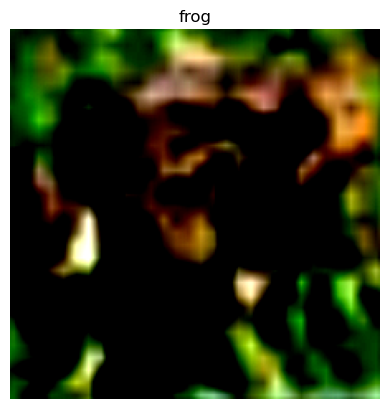

In [15]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [17]:
for param in vit_l_16_model.parameters():
    param.requires_grad = False

In [18]:
vit_l_16_model.heads.requires_grad_ = True # unfreezing classifier

vit_l_16_model.heads = nn.Linear(in_features=1024, out_features=len(class_names), device=device)

In [19]:
summary(model=vit_l_16_model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             1,024                Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   (787,456)            False
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              False
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      (12,596,224)         False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 

In [20]:
def manual_seed():
    torch.cuda.manual_seed(1)
    np.random.seed(1)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr=0.001, params=vit_l_16_model.parameters(), momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(T_max=500, optimizer=optimizer, verbose=False)
manual_seed()
from train_model import train
vit_l_16_model_results = train(model=vit_l_16_model,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              lr_scheduler=lr_scheduler,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              device=device,
                              epochs=14)

  7%|▋         | 1/14 [13:41<2:57:58, 821.44s/it]

Epoch: 1 | train_loss: 0.3398 | train_acc: 0.9057 | test_loss: 0.2416 | test_acc: 0.9240


 14%|█▍        | 2/14 [25:17<2:29:30, 747.51s/it]

Epoch: 2 | train_loss: 0.2118 | train_acc: 0.9324 | test_loss: 0.2186 | test_acc: 0.9301


 21%|██▏       | 3/14 [36:53<2:12:46, 724.25s/it]

Epoch: 3 | train_loss: 0.1919 | train_acc: 0.9382 | test_loss: 0.2077 | test_acc: 0.9313


 29%|██▊       | 4/14 [48:30<1:58:55, 713.52s/it]

Epoch: 4 | train_loss: 0.1793 | train_acc: 0.9425 | test_loss: 0.2015 | test_acc: 0.9331


 36%|███▌      | 5/14 [1:00:08<1:46:09, 707.68s/it]

Epoch: 5 | train_loss: 0.1707 | train_acc: 0.9445 | test_loss: 0.1965 | test_acc: 0.9360


 43%|████▎     | 6/14 [1:11:45<1:33:52, 704.07s/it]

Epoch: 6 | train_loss: 0.1640 | train_acc: 0.9470 | test_loss: 0.1939 | test_acc: 0.9355


 50%|█████     | 7/14 [1:23:22<1:21:51, 701.70s/it]

Epoch: 7 | train_loss: 0.1583 | train_acc: 0.9487 | test_loss: 0.1906 | test_acc: 0.9366


 57%|█████▋    | 8/14 [1:34:58<1:10:00, 700.16s/it]

Epoch: 8 | train_loss: 0.1536 | train_acc: 0.9504 | test_loss: 0.1886 | test_acc: 0.9383


 64%|██████▍   | 9/14 [1:46:36<58:16, 699.27s/it]  

Epoch: 9 | train_loss: 0.1495 | train_acc: 0.9520 | test_loss: 0.1870 | test_acc: 0.9385


 71%|███████▏  | 10/14 [1:58:13<46:34, 698.52s/it]

Epoch: 10 | train_loss: 0.1461 | train_acc: 0.9528 | test_loss: 0.1853 | test_acc: 0.9392


 79%|███████▊  | 11/14 [2:09:50<34:54, 698.10s/it]

Epoch: 11 | train_loss: 0.1430 | train_acc: 0.9534 | test_loss: 0.1848 | test_acc: 0.9406


 86%|████████▌ | 12/14 [2:21:26<23:15, 697.58s/it]

Epoch: 12 | train_loss: 0.1404 | train_acc: 0.9545 | test_loss: 0.1829 | test_acc: 0.9401


 93%|█████████▎| 13/14 [2:33:01<11:36, 696.76s/it]

Epoch: 13 | train_loss: 0.1377 | train_acc: 0.9548 | test_loss: 0.1830 | test_acc: 0.9399


100%|██████████| 14/14 [2:44:36<00:00, 705.44s/it]

Epoch: 14 | train_loss: 0.1353 | train_acc: 0.9557 | test_loss: 0.1824 | test_acc: 0.9408
